In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
from wordcloud import WordCloud
from xgboost import XGBClassifier
import re

# Load dataset
raw_data = pd.read_csv("fake_job_postings.csv")
raw_data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [2]:
print("Raw Data Info:")
print(raw_data.info())
print("\nRaw Data Missing Values:")
print(raw_data.isnull().sum())
print("\nRaw Data Unique Values:")
print(raw_data.nunique())

Raw Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  o

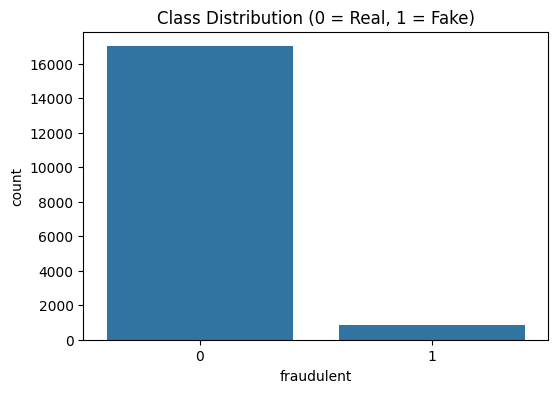

In [3]:
# Visual EDA
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=raw_data)
plt.title('Class Distribution (0 = Real, 1 = Fake)')
plt.show()

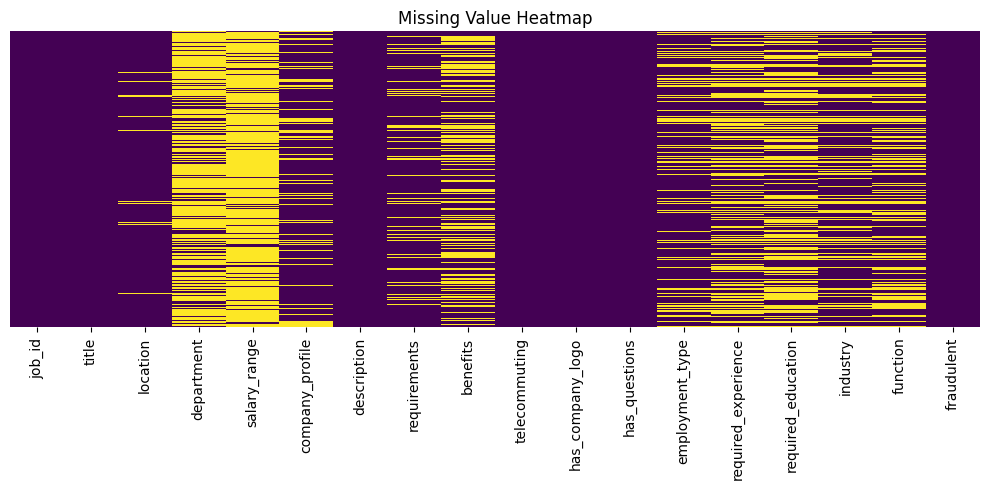

In [4]:
plt.figure(figsize=(10, 5))
sns.heatmap(raw_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.tight_layout()
plt.show()

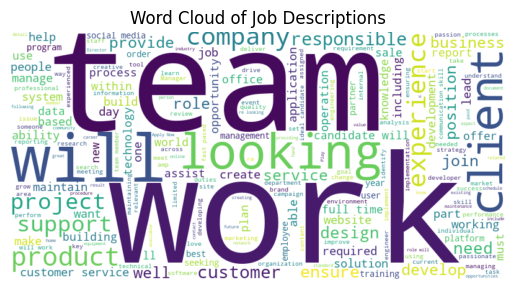

In [5]:
wordcloud_text = ' '.join(raw_data['description'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Job Descriptions')
plt.show()

In [6]:
# Enhanced EDA (Tabular + Visual)
eda_columns = ['fraudulent', 'telecommuting', 'has_company_logo', 'has_questions',
               'employment_type', 'required_experience', 'required_education',
               'industry', 'function']

# Tabular Summary
eda_summary = raw_data[eda_columns].describe(include='all').transpose()
display(eda_summary)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fraudulent,17880.0,NaN,NaN,NaN,0.048434,0.214688,0.0,0.0,0.0,0.0,1.0
telecommuting,17880.0,NaN,NaN,NaN,0.042897,0.202631,0.0,0.0,0.0,0.0,1.0
has_company_logo,17880.0,NaN,NaN,NaN,0.795302,0.403492,0.0,1.0,1.0,1.0,1.0
has_questions,17880.0,NaN,NaN,NaN,0.491723,0.499945,0.0,0.0,0.0,1.0,1.0
employment_type,14409,5,Full-time,11620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_experience,10830,7,Mid-Senior level,3809,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_education,9775,13,Bachelor's Degree,5145,NaN,NaN,NaN,NaN,NaN,NaN,NaN
industry,12977,131,Information Technology and Services,1734,NaN,NaN,NaN,NaN,NaN,NaN,NaN
function,11425,37,Information Technology,1749,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/w4/bn_1ypy914n7428ssx7qhnrh0000gn/T/ipykernel_38466/2070040242.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='magma')


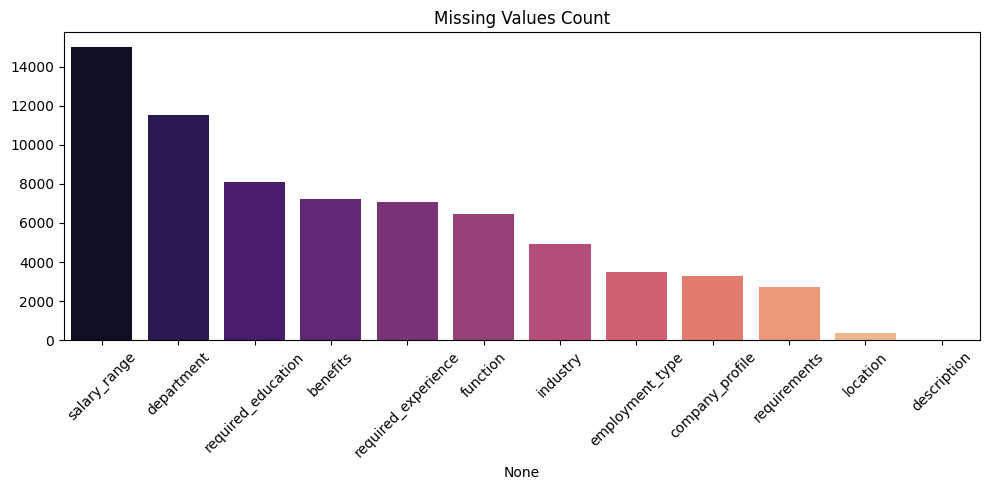

In [7]:
# Missing Value Plot
missing_counts = raw_data.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='magma')
plt.title("Missing Values Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

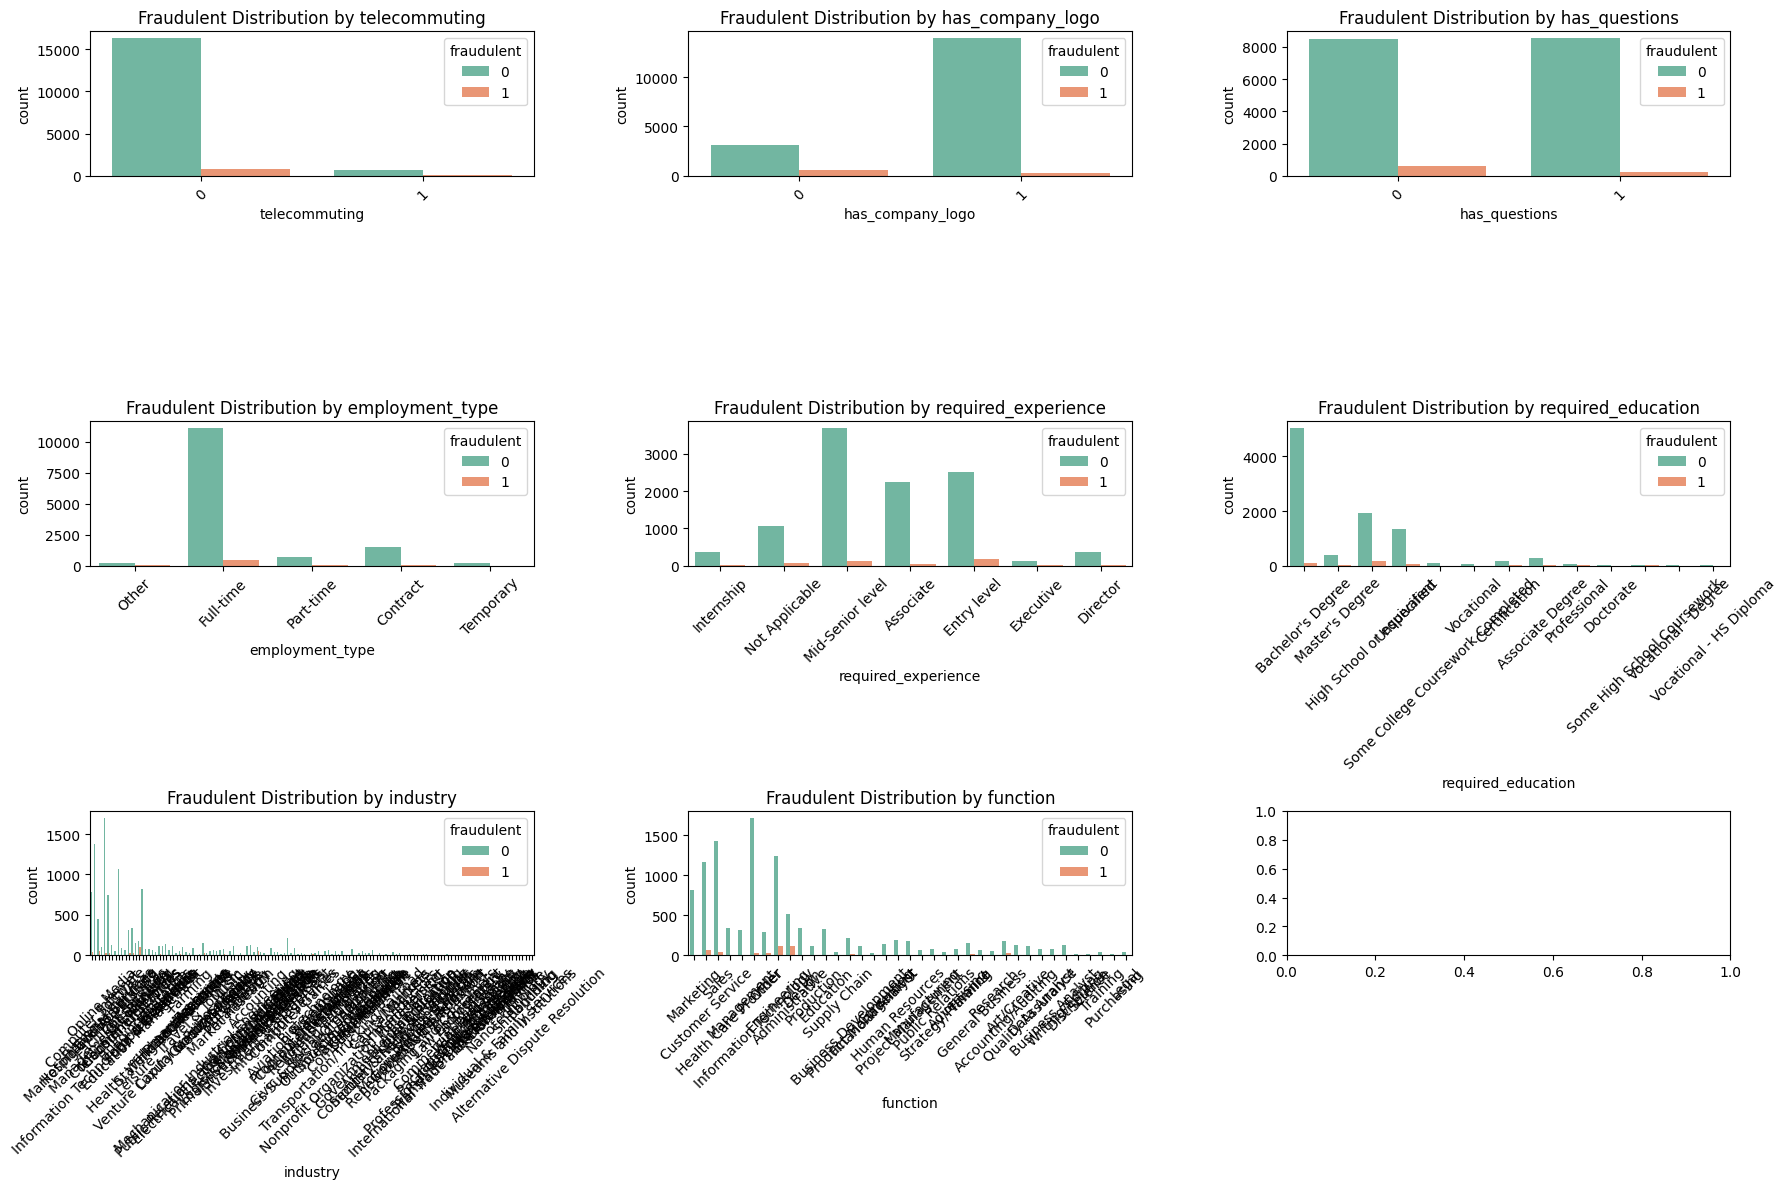

In [8]:
# Fraudulent vs Categorical Features
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()
for idx, col in enumerate(eda_columns[1:]):
    sns.countplot(data=raw_data, x=col, hue='fraudulent', ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'Fraudulent Distribution by {col}')
    axes[idx].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Clean 
data = raw_data.copy()
data.drop(columns=['job_id'], inplace=True, errors='ignore')
data.dropna(subset=['title', 'description'], inplace=True)
def extract_years_experience(text):
    matches = re.findall(r'(\\d+)\\s*\\+?\\s*(?:years?|yrs?)', text.lower())
    return int(matches[0]) if matches else 0


text_fields = ['title', 'description', 'requirements', 'company_profile', 'benefits']
for col in text_fields:
    data[col] = data[col].fillna('')
data['combined_text'] = data['title'] + ' ' + data['description'] + ' ' + data['requirements'] + ' ' + data['company_profile'] + ' ' + data['benefits']
data['years_experience'] = (data['requirements'] + ' ' + data['description']).apply(extract_years_experience)

In [10]:
def count_suspicious_keywords(text):
    keywords = [
        'money', 'quick', 'no experience', 'easy', 'limited time', 'guarantee', 'click here',
        'winner', 'urgent', 'apply now', 'limited spots', 'make money', 'investment opportunity',
        'immediate start', 'work from home', 'crypto', 'bitcoin', 'wire transfer', 'cash reward',
        'get paid', 'no interview', 'sign up bonus', 'unlimited earning', '100% free', 'fast cash'
    ]
    return sum([len(re.findall(rf'\b{re.escape(kw)}\b', text.lower())) for kw in keywords])

data['suspicious_keyword_count'] = data['combined_text'].apply(count_suspicious_keywords)
data['min_salary'] = data['salary_range'].str.extract(r'(\d+)').astype(float)
data['max_salary'] = data['salary_range'].str.extract(r'-(\d+)').astype(float)
data['avg_salary'] = data[['min_salary', 'max_salary']].mean(axis=1)
data['missing_salary_flag'] = data['avg_salary'].isna().astype(int)
data['is_remote_flag'] = data['location'].str.lower().str.contains('remote', na=False).astype(int)
data['fraudulent'] = data['fraudulent'].astype(int)
data.drop(columns=['salary_range'], inplace=True)

data.head()

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,function,fraudulent,combined_text,years_experience,suspicious_keyword_count,min_salary,max_salary,avg_salary,missing_salary_flag,is_remote_flag
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,...,Marketing,0,"Marketing Intern Food52, a fast-growing, James...",0,0,NaN,NaN,NaN,1,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,...,Customer Service,0,Customer Service - Cloud Video Production Orga...,0,3,NaN,NaN,NaN,1,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,...,NaN,0,Commissioning Machinery Assistant (CMA) Our cl...,0,0,NaN,NaN,NaN,1,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,...,Sales,0,Account Executive - Washington DC THE COMPANY:...,0,2,NaN,NaN,NaN,1,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,...,Health Care Provider,0,Bill Review Manager JOB TITLE: Itemization Rev...,0,0,NaN,NaN,NaN,1,0



Average suspicious keyword count:
fraudulent
0    0.352651
1    0.636994
Name: suspicious_keyword_count, dtype: float64


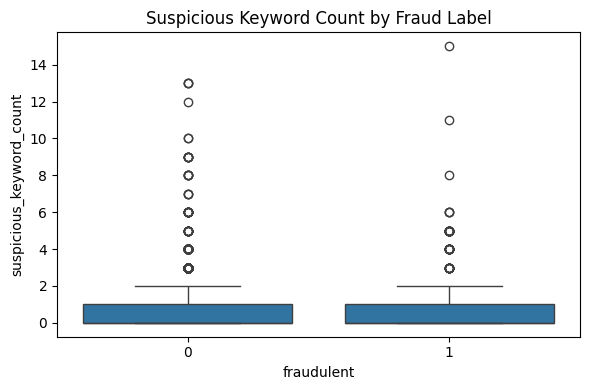

In [11]:
# Compare Suspicious Word Count by Label
avg_counts = data.groupby('fraudulent')['suspicious_keyword_count'].mean()
print("\nAverage suspicious keyword count:")
print(avg_counts)

plt.figure(figsize=(6, 4))
sns.boxplot(x='fraudulent', y='suspicious_keyword_count', data=data)
plt.title('Suspicious Keyword Count by Fraud Label')
plt.tight_layout()
plt.show()

### EDA After Feature Engineering:

In [12]:
# Summary statistics of new features
new_features = ['suspicious_keyword_count', 'min_salary', 'max_salary', 'avg_salary', 'missing_salary_flag', 'is_remote_flag']
print("Descriptive Stats for New Features:")
display(data[new_features].describe().T)

Descriptive Stats for New Features:


,count,mean,std,min,25%,50%,75%,max
suspicious_keyword_count,17879.0,0.366408,7.737247e-01,0.0,0.0,0.0,1.0,1.500000e+01
min_salary,2868.0,510737.623780,1.761278e+07,0.0,17375.0,35000.0,60000.0,8.000000e+08
max_salary,2846.0,811143.983837,2.703359e+07,0.0,25000.0,50000.0,90000.0,1.200000e+09
avg_salary,2868.0,657836.725593,2.226802e+07,0.0,21750.0,44000.0,72500.0,1.000000e+09
missing_salary_flag,17879.0,0.839588,3.669977e-01,0.0,1.0,1.0,1.0,1.000000e+00
is_remote_flag,17879.0,0.000392,1.978356e-02,0.0,0.0,0.0,0.0,1.000000e+00


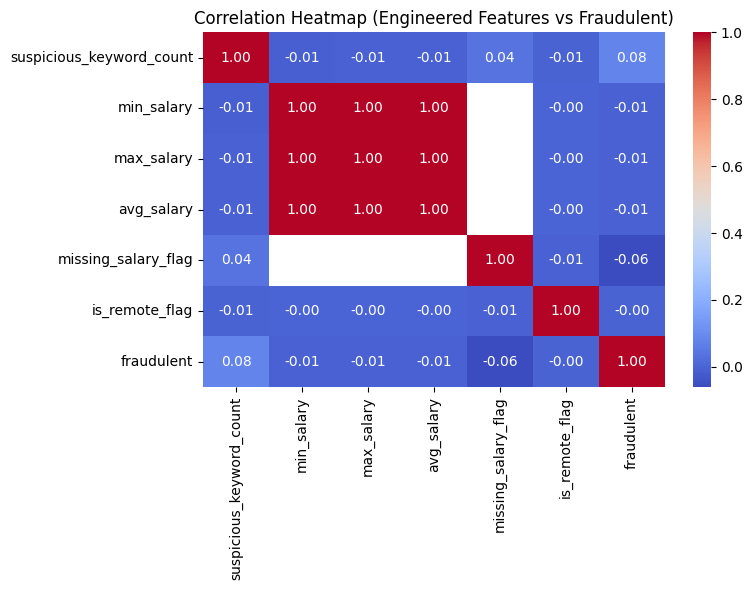

In [13]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data[new_features + ['fraudulent']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap (Engineered Features vs Fraudulent)")
plt.tight_layout()
plt.show()

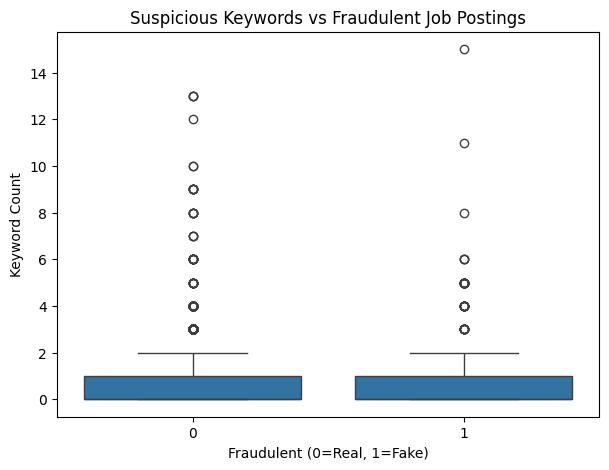

In [14]:
# Countplot: Suspicious Keywords vs Fraudulent
plt.figure(figsize=(7, 5))
sns.boxplot(x='fraudulent', y='suspicious_keyword_count', data=data)
plt.title("Suspicious Keywords vs Fraudulent Job Postings")
plt.xlabel("Fraudulent (0=Real, 1=Fake)")
plt.ylabel("Keyword Count")
plt.show()

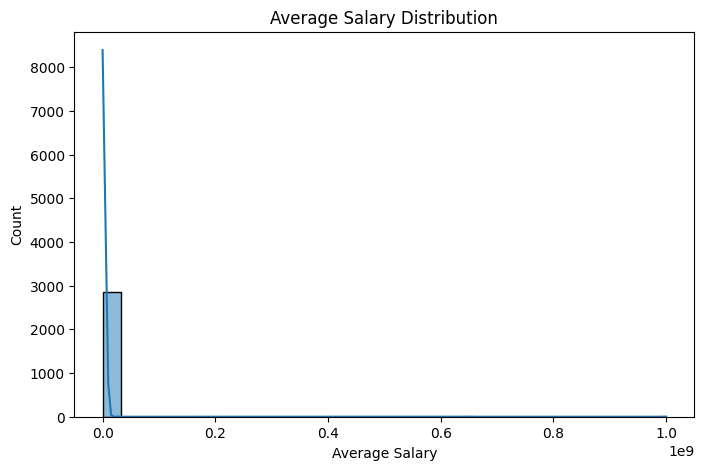

In [15]:
# Avg Salary Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['avg_salary'].dropna(), bins=30, kde=True)
plt.title("Average Salary Distribution")
plt.xlabel("Average Salary")
plt.show()

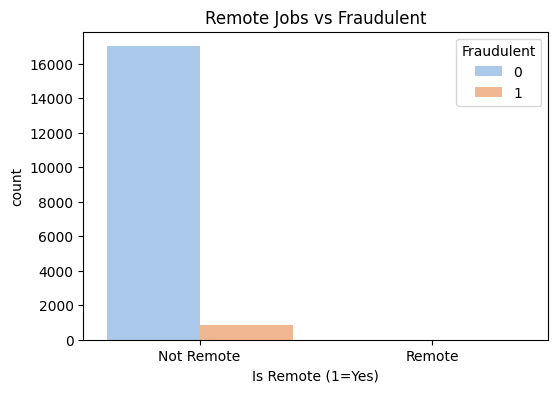

In [16]:
# Remote vs Fraudulent
plt.figure(figsize=(6, 4))
sns.countplot(x='is_remote_flag', hue='fraudulent', data=data, palette='pastel')
plt.title("Remote Jobs vs Fraudulent")
plt.xlabel("Is Remote (1=Yes)")
plt.xticks([0, 1], ['Not Remote', 'Remote'])
plt.legend(title='Fraudulent')
plt.show()

In [17]:
# Text Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=7000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(data['combined_text'])

# Combine and Split
numeric_features = data[['avg_salary', 'missing_salary_flag', 'is_remote_flag', 'suspicious_keyword_count', 'years_experience']].fillna(0)
X = hstack([tfidf_matrix, numeric_features])
y = data['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

/Users/viranchi/Library/Mobile Documents/com~apple~CloudDocs/Binghamton/SEM 2 Bing/Applied Data Mining/Projects/Final Project DM/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### # Model Training:

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

# Use SMOTE-resampled training data
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled) 
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        "Accuracy": round(acc * 100, 2),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True)
    }


In [19]:
# Tabular Comparison
results_df = pd.DataFrame({name: [info["Accuracy"]] for name, info in results.items()}, index=["Accuracy"]).T
display(results_df)

,Accuracy
XGBoost,98.85
Logistic Regression,73.24
Random Forest,98.57


/var/folders/w4/bn_1ypy914n7428ssx7qhnrh0000gn/T/ipykernel_38466/3938382372.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Accuracy", data=results_df.reset_index(), palette='Set1')


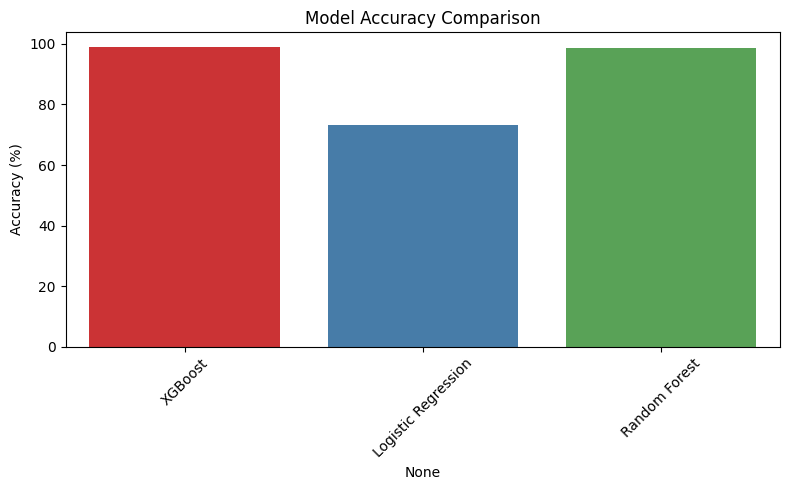

In [20]:
# Visual Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=results_df.index, y="Accuracy", data=results_df.reset_index(), palette='Set1')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Select best model
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]
print(f"Best model selected: {best_model_name}")

Best model selected: XGBoost


In [22]:
# Save the best model and TF-IDF vectorizer for use in Streamlit
import joblib

joblib.dump(best_model, "best_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("Model and TF-IDF vectorizer saved successfully.")

Model and TF-IDF vectorizer saved successfully.


In [23]:
from sklearn.metrics import confusion_matrix, roc_auc_score

for name, model in models.items():
    print(f"\n==============================")
    print(f" Evaluation for {name}")
    print(f"==============================")
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    if y_proba is not None:
        print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    else:
        print("ROC-AUC Score: Not available for this model")



 Evaluation for XGBoost
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.80      0.87       173

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576

Confusion Matrix:
 [[3396    7]
 [  34  139]]
ROC-AUC Score: 0.9894499752853227

 Evaluation for Logistic Regression
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84      3403
           1       0.06      0.30      0.10       173

    accuracy                           0.73      3576
   macro avg       0.51      0.53      0.47      3576
weighted avg       0.91      0.73      0.81      3576

Confusion Matrix:
 [[2567  836]
 [ 121   52]]
ROC-AUC Score: 0.6166091123269336

 Evaluation for Random Forest
Classification Report:
               precisi

### Feature Importance Plot (Best Model)

/var/folders/w4/bn_1ypy914n7428ssx7qhnrh0000gn/T/ipykernel_38466/144434292.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=feature_names, palette='Set2')


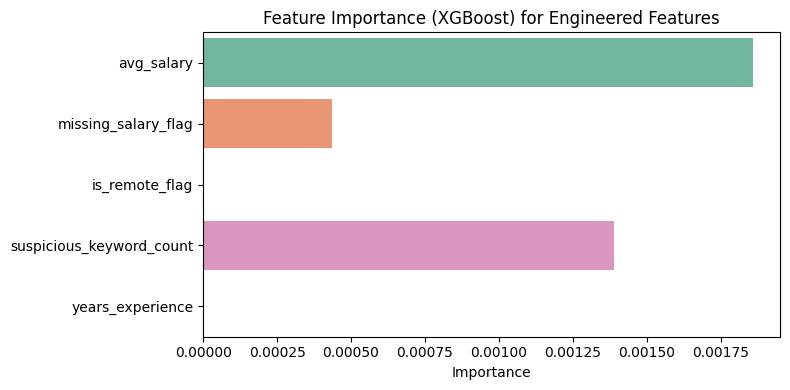

In [24]:
import numpy as np

feature_names = ['avg_salary', 'missing_salary_flag', 'is_remote_flag', 'suspicious_keyword_count', 'years_experience']
start_idx = X_train_resampled.shape[1] - len(feature_names)  # Position of engineered features in the vector

if hasattr(best_model, "feature_importances_"):
    # XGBoost or RandomForest
    importance = best_model.feature_importances_[-len(feature_names):]
elif hasattr(best_model, "coef_"):
    # Logistic Regression
    importance = np.abs(best_model.coef_[0][-len(feature_names):])
else:
    importance = None

if importance is not None:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=importance, y=feature_names, palette='Set2')
    plt.title(f"Feature Importance ({best_model_name}) for Engineered Features")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance not available for model: {best_model_name}")

In [25]:
import random

max_attempts = 10
for _ in range(max_attempts):
    sample_data = data.sample(20, random_state=random.randint(1, 10000)).copy()
    if set(sample_data['fraudulent']) == {0, 1}:
        break
else:
    raise ValueError("Unable to sample both classes in 20 rows after multiple attempts.")

# Process features
sample_text = sample_data['combined_text']
sample_tfidf = tfidf.transform(sample_text)

sample_numeric = sample_data[['avg_salary', 'missing_salary_flag', 'is_remote_flag',
                              'suspicious_keyword_count', 'years_experience']].fillna(0)

sample_combined = hstack([sample_tfidf, sample_numeric])

# Predict
sample_preds = best_model.predict(sample_combined)
sample_data['Predicted Fraudulent'] = sample_preds

# Display predictions
display(sample_data[['title', 'location', 'fraudulent', 'Predicted Fraudulent']])

,title,location,fraudulent,Predicted Fraudulent
7970,IT Project Technician,"US, TX, Temple",0,0
8611,Systems Administrator,"US, PA, Pittsburgh",0,0
10066,"Dropoff Driver ""Agent"" - Austin","US, TX, Austin",0,0
3960,SAP HR Functional Consultant,"US, NE, Omaha",0,0
1176,Digital Account Manager,"GB, , London",0,0
6611,Graduates: English Teacher Abroad (Conversatio...,"US, OH, Kent",0,0
7658,Admin Clerical Data Processor,"US, TX, Houston",1,1
9445,Care Assistant (Personal Assistant),"GB, EDH, Edinburgh South and South East",0,0
7877,"ENG Camera Operator, Broadcast Operations Divi...","US, DC, Washington",0,0
3237,Android Developer,"CZ, PR, Praha",0,0


/var/folders/w4/bn_1ypy914n7428ssx7qhnrh0000gn/T/ipykernel_38466/3899682055.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Predicted Fraudulent', data=sample_data, palette='Set2')


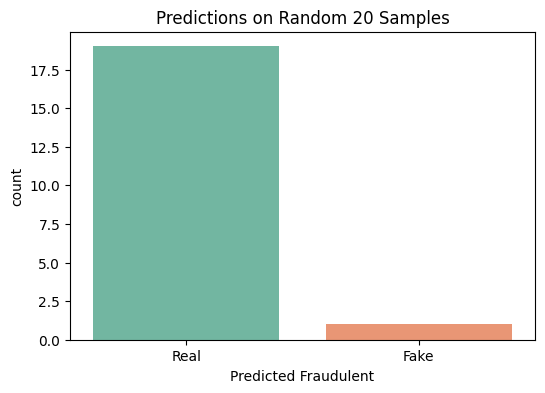

In [26]:
# Visualize predictions
plt.figure(figsize=(6, 4))
sns.countplot(x='Predicted Fraudulent', data=sample_data, palette='Set2')
plt.title("Predictions on Random 20 Samples")
plt.xticks([0, 1], ['Real', 'Fake'])
plt.show()